In [1]:
import pickle
import numpy as np
import pandas as pd
import nltk
import string
import sys
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix, dok_matrix
from scipy.sparse.linalg import svds
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, matthews_corrcoef, classification_report

#### First separate the data into a training and test set

In [2]:
df = pd.read_csv("emails.csv")
X = df.Text
y = df.Spam
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Now we will process the data into a TF-IDF matrix format

- Start with getting the set of all words, and pre-process the text strings into lists of words

In [3]:
def get_words(document: list[list[str]]):
    for word in nltk.tokenize.word_tokenize(document):
        if word not in string.punctuation:
            yield word.lower()

In [4]:
def process_documents(data):
    all_words = {}; index = 0
    emails = []
    
    for email in data:
        current = []
        for word in get_words(email):
            if word not in all_words:
                all_words|= {word:index}
                index+=1
            current.append(word)
        emails.append(current)
    return all_words, emails


def process_test_documents(data, all_words):
    emails = []
    for email in data:
        current = []
        for word in get_words(email):
            if word in all_words:
                current.append(word)
        emails.append(current)
    return emails

In [5]:
all_words, emails = process_documents(X_train)

- With the data preprocessed we can easily compute the TF IDF with the following functions

In [6]:
def count_words(
    words: list[str]
) -> dict[str, int]:
    """
    Counts the ocurrence of each word in the document corpus.
    """
    return dict(zip(*np.unique(words, return_counts=True)))


def tf(
    word_counts: dict[str, int], 
    i: int,
    all_words: dict[str, int], 
    TF_Matrix: dok_matrix
) -> None:
    """
    Computes the Term-Frequency vector of a document. 
    Operates in-memory in the Term-Frequency Matrix, receiving the index {i} that corresponds to the document.
    """
    counts = word_counts.values()
    if len(counts)==0: return {}
    max_value = max(counts)
    
    for word, counts in word_counts.items():
        TF_Matrix[i, all_words[word]] = counts/max_value
    
    
def calc_sparse_tf_matrix(
    docs: list[list[str]], 
    all_words: dict[str, int], 
    TF_Matrix:dok_matrix
)->dok_matrix:
    """
    Computes the Term-Frequency Matrix
    """
    for i, doc in enumerate(docs):
        word_counts = count_words(doc)
        tf(word_counts, i, all_words, TF_Matrix)
    return TF_Matrix

In [7]:
def calc_idf(
    documents: list[list[str]],
    all_words: dict[str, int],
    IDF_Matrix: dok_matrix
) -> dok_matrix:
    """
    Computes the Inverse Document Frequency in-memory.
    """
    N = len(documents)
    
    for doc in documents:
        for word in np.unique(doc):
            IDF_Matrix[ 0, all_words[word] ] += 1
    
    for i in range(IDF_Matrix.shape[1]):
        IDF_Matrix[0, i] = np.log2(N / (IDF_Matrix[0, i] + 1) ) + 1
    return IDF_Matrix

In [8]:
def calc_tf_idf(
    all_words: dict[str, int],
    documents: list[list[str]]
) -> dok_matrix :
    """
    Calculates TF-IDF matrix
    """
    N = len(documents)
    M = len(all_words)
    
    TF = dok_matrix(np.zeros( (N, M) ))
    IDF = dok_matrix(np.zeros( (1, M) ))
    
    TF = calc_sparse_tf_matrix(documents, all_words, TF).tocsr()
    IDF = calc_idf(documents, all_words, IDF).tocsr()
    
    print("TF size =", sys.getsizeof(pickle.dumps(TF))/1024**2, "MB")
    print("IDF size =", sys.getsizeof(pickle.dumps(IDF))/1024**2, "MB")
    
    TF_IDF = TF.multiply(IDF)
    return TF_IDF

In [9]:
TF_IDF = calc_tf_idf(all_words, emails)

TF size = 6.801630973815918 MB
IDF size = 0.38732337951660156 MB


### Now we will train the model with the sparse matrix and check the results

First we will use the full dataset

Afterwards the data will be decomposed using SVD to reduce dimensionality and the process will be repeated


#### Using Full dataset
    - SVM

In [92]:
svm = SVC(kernel="linear").fit(TF_IDF, y_train)

In [93]:
svm.score(TF_IDF, y_train)

1.0

In [54]:
test_words = process_test_documents(X_test, all_words)

In [55]:
TF_IDF_test = calc_tf_idf(all_words, test_words)

TF size = 1.6422529220581055 MB
IDF size = 0.38732337951660156 MB


MCC = 0.9751002951582475
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       885
           1       0.99      0.97      0.98       261

    accuracy                           0.99      1146
   macro avg       0.99      0.98      0.99      1146
weighted avg       0.99      0.99      0.99      1146



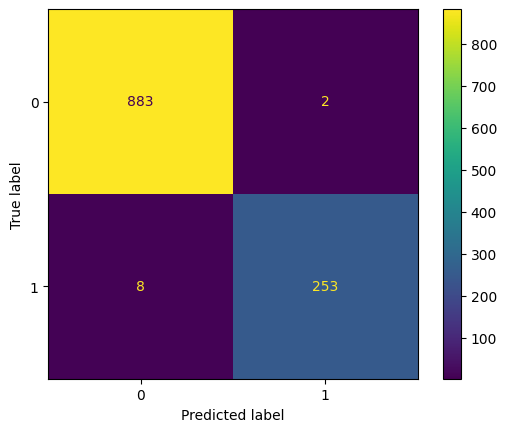

In [94]:
preds = svm.predict(TF_IDF_test)

print("MCC =", matthews_corrcoef(y_test, preds))
print(classification_report(y_test,preds))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()

 - Random Forest

In [57]:
rfc = RandomForestClassifier().fit(TF_IDF, y_train)
rfc.score(TF_IDF, y_train)

1.0

MCC = 0.8973280580543422
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       885
           1       1.00      0.85      0.92       261

    accuracy                           0.96      1146
   macro avg       0.98      0.92      0.95      1146
weighted avg       0.97      0.96      0.96      1146



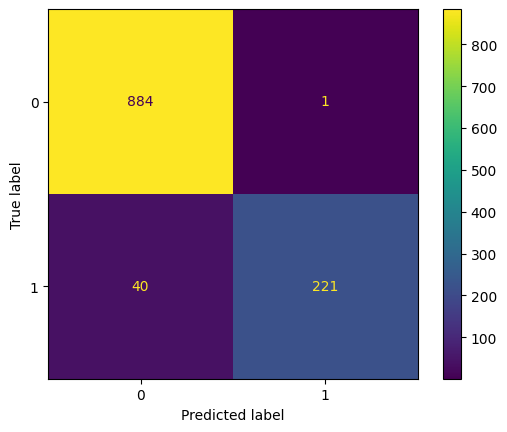

In [58]:
preds = rfc.predict(TF_IDF_test)

print("MCC =", matthews_corrcoef(y_test, preds))
print(classification_report(y_test,preds))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()

#### Dimensionality Reduction using SVD

In [37]:
TF_IDF

<4582x33811 sparse matrix of type '<class 'numpy.float64'>'
	with 588192 stored elements in Compressed Sparse Row format>

In [ ]:
#s = np.linalg.svd(TF_IDF.toarray(), compute_uv=False)
#diag_ratios = s**2 / (s**2).sum()

#np.cumsum(diag_ratios)[1795]

In [99]:
u,s,v = svds(TF_IDF, k=30)

In [100]:
u.shape, s.shape, v.shape

((4582, 30), (30,), (30, 33811))

- SVM

In [101]:
svm = SVC(kernel="linear").fit(u, y_train)
svm.score(u, y_train)

0.8020515058926233

In [102]:
TF_IDF_test

<1146x33811 sparse matrix of type '<class 'numpy.float64'>'
	with 143086 stored elements in Compressed Sparse Row format>

In [103]:
u_test =  TF_IDF_test @ v.T

MCC = 0.7942740393431118
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       885
           1       0.73      0.98      0.84       261

    accuracy                           0.91      1146
   macro avg       0.86      0.94      0.89      1146
weighted avg       0.93      0.91      0.92      1146



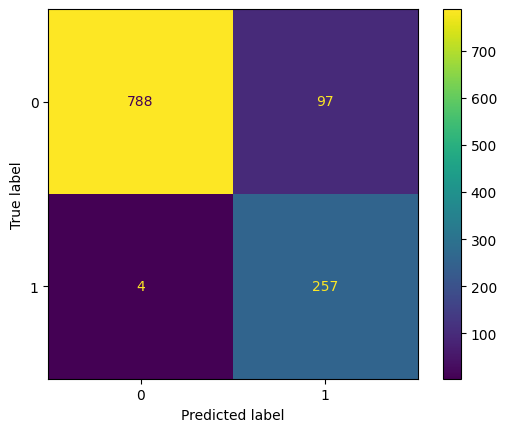

In [104]:
preds = svm.predict(u_test)

print("MCC =", matthews_corrcoef(y_test, preds))
print(classification_report(y_test,preds))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()

By reducing the space to 30 dimensions only we worsen a bit our module but the impact it had in False positives was not much changed.

What suffered more impact was the False Positives.

- Random Forest

In [105]:
rfc = RandomForestClassifier().fit(u, y_train)
rfc.score(u, y_train)

1.0

MCC = 0.5050242046095502
              precision    recall  f1-score   support

           0       0.99      0.62      0.76       885
           1       0.43      0.98      0.60       261

    accuracy                           0.70      1146
   macro avg       0.71      0.80      0.68      1146
weighted avg       0.86      0.70      0.72      1146



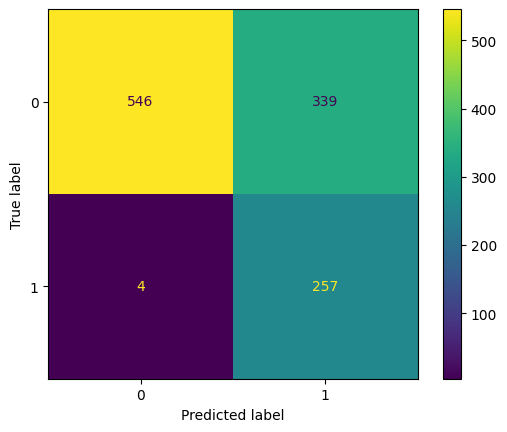

In [106]:
preds = rfc.predict(u_test)

print("MCC =", matthews_corrcoef(y_test, preds))
print(classification_report(y_test,preds))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()